In [31]:
from tensorflow.keras.datasets import boston_housing
import keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [32]:
class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [ ]:
def get_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)  
    ])
    
    model.compile(optimizer="rmsprop",
              loss="mse",
              metrics=[RootMeanSquaredError()])
    
    return model

(train_data, train_targets), (test_data, test_targes) = boston_housing.load_data()

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [ ]:
k = 4
num_val_samples = len(train_data) // k

num_epochs = 100
all_mae_histories = []
for i in range(k):
    print(f"#{i}번째 폴드 처리중")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = get_model()

    with tf.device('/gpu:0'):
        history = model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs,
                validation_data=(val_data, val_targets),
                batch_size=20,
                verbose=0)

#0번째 폴드 처리중
#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중


In [35]:
all_mae_histories = []
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history) 

In [36]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

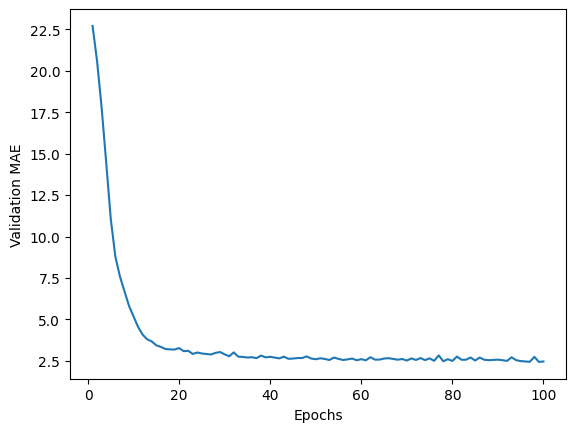

In [37]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [38]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targes)

test_mae_score

4/4 [==============================] - 0s 5ms/step - loss: 22.9178 - mae: 2.9348


2.934802293777466

In [26]:
all_rmse_histories = []
rmse_history = history.history['val_rmse']
all_rmse_histories.append(rmse_history) 

In [27]:
average_rmse_history = [np.mean([x[i] for x in all_rmse_histories]) for i in range(num_epochs)]

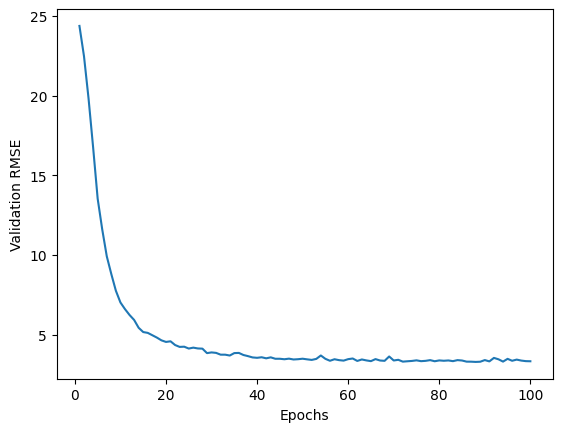

In [28]:
plt.plot(range(1, len(average_rmse_history) + 1), average_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("Validation RMSE")
plt.show()

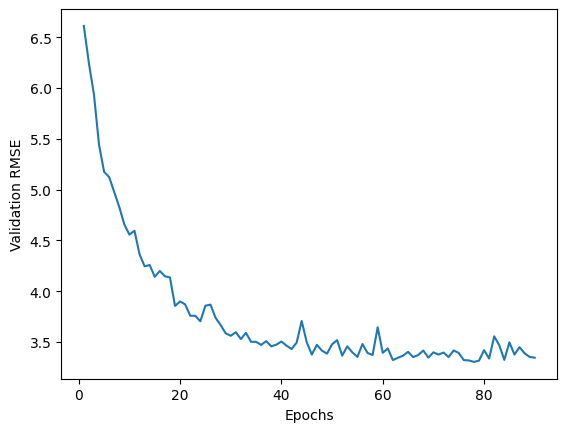

In [29]:
truncated_rmse_history = average_rmse_history[10:]
plt.plot(range(1, len(truncated_rmse_history) + 1), truncated_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("Validation RMSE")
plt.show()

In [30]:
test_mse_score, test_rmse_score = model.evaluate(test_data, test_targes)

test_rmse_score

4/4 [==============================] - 0s 3ms/step - loss: 23.4598 - rmse: 4.8435


4.843527793884277

In [ ]:
model = get_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_rmse_score = model.evaluate(test_data, test_targes)

4/4 [==============================] - 0s 5ms/step - loss: 15.0431 - mae: 2.5015


In [ ]:
test_rmse_score

2.501450538635254

조정민: 보스턴 주택 가격 데이터셋을 활용해서 rmse 사용자 정의 지표로 모델을 학습 시켰으나 그래프가 비정상적으로 나오는 모습을 보아 해당 부분을 수정하느라 다양한 시도를 학습을 하지못한 부분이 아쉽습니다.

조계현: 초기목적은 달성한 것 같은데 학습결과가 안좋은것으로 보아 사용자지정 rmse함수에 수정할 부분이 있는 것 같다.  

고은비: 추후 커스터마이즈된 모델을 사용할 수 있도록, 사용자 지표 및 콜백 클래스를 정의하는 학습을 하였는데, 처음 설계 시 예상해보았던 결과처럼 값이 쉽게 구해지지 않았다. 어떠한 부분에서 수정할 필요가 있는지 계속 논의하였지만, 아직은 결론에 도달하지 못하였다.